# Implementing and Training ConvCNPs for Hydrology 

The ConvCNP ([Convolutional Conditional Neural Process](https://openreview.net/forum?id=Skey4eBYPS)) is a recently introduced member of the neural process family that leverages translation equivariance as an inductive bias when performing inference on sets. This repository contains the  necessary classes and scripts to reproduce the 1d experiments using the CAMELS hydrological dataset.

In [1]:
import os 
os.getcwd()

'/home/donal/Documents/mg963/MResProject/convcnp/convcnp'

In [2]:
#os.chdir('c:\\Users\\marcg\\Google Drive\\MResProject')
#!pip install -r requirements.txt

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import time, datetime
import pandas as pd
import pdb
import torch
import torch.nn as nn
import pickle

from sklearn import preprocessing
from scipy.special import inv_boxcox
from scipy.stats import boxcox
#import stheno.torch as stheno

#import convcnp.data
import convcnp.data_hydro_2
import convcnp.data_hydro_2_extended
import convcnp.data_365
import convcnp.data_loader_pytorch
import NSE
from metrics import *
#import convcnp.task_preprocessing as tp

from convcnp.experiment import report_loss, RunningAverage
from convcnp.utils import gaussian_logpdf, gamma_logpdf, init_sequential_weights, to_multiple, to_numpy, gamma_stats
from convcnp.plot_utils import *
from convcnp.transformations import *
from convcnp.architectures import SimpleConv, UNet, SeparableConv1d, Conv1d, DepthSepConv1d
from convcnp.convcnp_architectures import DeepSet, ConvDeepSet, FinalLayer, ConvCNP

from numpy import loadtxt

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(device)

cuda


In [4]:
%%time
filepath = r'../../data/camels_processed/daymet_merged/daymet_data_seed05.csv'
df_raw = pd.read_csv(filepath)

CPU times: user 11 s, sys: 1.11 s, total: 12.1 s
Wall time: 12.1 s


In [5]:
basins_file = r'../../../ealstm_regional_modelling/ealstm_regional_modeling/data/basin_list.txt'
selected_basins = loadtxt(basins_file, comments="#", delimiter=",", unpack=False, dtype="int")

In [6]:
%%time

df_raw = df_raw[df_raw['basin'].isin(selected_basins)]
print("Length of dataframe for selected basin: ", len(df_raw))

df_raw.drop(['MOD_RUN'],axis=1,inplace=True)

df_raw.drop_duplicates(inplace=True)
print("Length of dataframe after dropping duplicates: ", len(df_raw))

df_raw = df_raw[df_raw['OBS_RUN']>=0]
#df_raw[df_raw['OBS_RUN']<0] = 0
print("Length of dataframe after filtering out error values: ", len(df_raw))

df = df_raw.copy()

Length of dataframe for selected basin:  6521041
Length of dataframe after dropping duplicates:  6520841
Length of dataframe after filtering out error values:  6518953
CPU times: user 13.7 s, sys: 1.75 s, total: 15.5 s
Wall time: 15.5 s


In [7]:
dist='gamma'
transformation = 'log'
trans_fields = ['OBS_RUN','prcp(mm/day)']

if transformation == 'log':
    for trans_field in trans_fields:
        df[trans_field] = log_transform(df_raw[trans_field], 1)
if transformation == 'boxcox':
    for trans_field in trans_fields:
        df[trans_field], lambda_val = boxcox_transform(df_raw[trans_field], 1e-6)
        
        for ch in ['(',')','/']:
            trans_field = trans_field.replace(ch,"_")
        
        exec("lambda_" + trans_field + " = " + str(lambda_val))
        print("lambda_" + trans_field + " = ", lambda_val)

if dist=='gamma':
    Q_shift = df['OBS_RUN'].min()
    df['OBS_RUN'] = df['OBS_RUN'] + Q_shift + 1

In [8]:
%%capture
"""OBS_RUN_min = df['OBS_RUN'].min()
OBS_RUN_max = df['OBS_RUN'].max()

#OBS_RUN_min = df_raw['OBS_RUN'].min()
#OBS_RUN_max = df_raw['OBS_RUN'].max()

df_raw['OBS_RUN_log'] = df_raw['OBS_RUN'].transform(lambda x: np.log(x + 1))
df_raw['OBS_RUN_log_n'] = df_raw['OBS_RUN_log'].transform(lambda x: (x - x.mean())/x.std())

mu_raw = df_raw['OBS_RUN'].mean()
sigma_raw = df_raw['OBS_RUN'].std()
mu_log = df_raw['OBS_RUN_log'].mean()
sigma_log = df_raw['OBS_RUN_log'].std()
mu_log_n = df_raw['OBS_RUN_log_n'].mean()
sigma_log_n = df_raw['OBS_RUN_log_n'].std()"""

In [9]:
fields = [#'OBS_RUN',
          'prcp(mm/day)', 
          'srad(W/m2)','swe(mm)', 'tmax(C)','tmin(C)', 'vp(Pa)',
         ]
for field in fields:
    #varname_mu = f'{field.split("(")[0]}_mu'
    #varname_sigma = f'{field.split("(")[0]}_sigma'
    #df[field], vars()[varname_mu], vars()[varname_sigma] = normalise(df[field])
    df[field] = normalise(df[field])

In [10]:
random_train_test_split = True

if random_train_test_split == True:
    fraction_test_locations = 0.1

    #hru02 = ['hru_01']
    hru02 = df['hru02'].unique().tolist()

    #hru04 = 'hru_0101'
    #hru08 = 'hru_01013500'

    hru08 = df['hru08'][df['hru02'].isin(hru02)].unique()
    #hru08 = df['hru08'] == 'hru_01013500'

    rand_locations = np.arange(len(hru08))
    np.random.shuffle(rand_locations)
    num_test_locations = int(len(hru08)*fraction_test_locations)
    rand_locations_test = rand_locations[0:num_test_locations]
    rand_locations_train = rand_locations[num_test_locations:]
    hru08_test = hru08[rand_locations_test]
    hru08_train = hru08[rand_locations_train]

    print(f'Train test split random: {len(rand_locations_train)} train and {len(rand_locations_test)} test locations')
    
else:
    path = 'train_test_splits/hru01_train_001.pkl'
    a_file = open(path, "rb")
    hru08_train = pickle.load(a_file)
    a_file.close()
    
    path = 'train_test_splits/hru01_test_001.pkl'
    a_file = open(path, "rb")
    hru08_test = pickle.load(a_file)
    a_file.close()
    
    print('Train test split not random')

Train test split random: 478 train and 53 test locations


In [11]:
df['OBS_RUN_mean'] = df.groupby('hru08')['OBS_RUN'].transform(lambda x: x.mean())
#df['OBS_RUN_log_n_mean'] = df.groupby('hru08')['OBS_RUN_log_n'].transform(lambda x: x.mean())

s_date_tr = '1980-10-01'
e_date_tr = '1995-09-30'

s_date_te = '1995-10-01'
e_date_te = '2010-09-30'

context_channels = ['OBS_RUN',
                    'doy_cos','doy_sin',
                    'prcp(mm/day)', 
                    'srad(W/m2)',  
                    'tmax(C)',
                    'tmin(C)', 
                    'vp(Pa)'
                   ]

target_channels = context_channels
target_val_channel = ['OBS_RUN_mean']

context_mask = [0,1,1,1,1,1,1,1]
target_mask = [0,1,1,1,1,1,1,1]

attributes = [#'gauge_id', 
               'p_mean', 'pet_mean', 'p_seasonality', 'frac_snow',
               'aridity', 'high_prec_freq', 'high_prec_dur', 
                #'high_prec_timing',
               'low_prec_freq', 'low_prec_dur', 
                #'low_prec_timing', 'geol_1st_class', 'glim_1st_class_frac', 'geol_2nd_class', 'glim_2nd_class_frac',
               'carbonate_rocks_frac', #'geol_porostiy', 
                'geol_permeability', 
                #'q_mean','runoff_ratio', 'slope_fdc', 'baseflow_index', 'stream_elas', 'q5',
               #'q95', 'high_q_freq', 'high_q_dur', 'low_q_freq', 'low_q_dur',
               #'zero_q_freq', 'hfd_mean', 'huc_02', 'gauge_name',
               'soil_depth_pelletier', 'soil_depth_statsgo', 'soil_porosity','soil_conductivity', 
                'max_water_content', 'sand_frac', 'silt_frac', 'clay_frac', 
                #'water_frac', 'organic_frac', 'other_frac', 
                #'gauge_lat','gauge_lon', 
                'elev_mean', 'slope_mean', 
                #'area_gages2',
                'area_geospa_fabric', 
                'frac_forest', 'lai_max', 'lai_diff', 'gvf_max','gvf_diff', 
                #'dom_land_cover_frac', 'dom_land_cover', 'root_depth_50','root_depth_99', 'hru08'
                ]

df_train = df[(df['DATE'] >= s_date_tr) & (df['DATE'] <= e_date_tr) & (df['hru08'].isin(hru08_train))].copy()
df_test_both = df[(df['DATE'] >= s_date_te) & (df['DATE'] <= e_date_te) & (df['hru08'].isin(hru08_test))].copy()
df_test_catchment = df[(df['DATE'] >= s_date_tr) & (df['DATE'] <= e_date_tr) & (df['hru08'].isin(hru08_test))].copy()
df_test_temporal = df[(df['DATE'] >= s_date_te) & (df['DATE'] <= e_date_te) & (df['hru08'].isin(hru08_train))].copy()

list_to_drop = ['MNTH','DY','hru02','hru04','RAIM','TAIR','PET','ET','SWE','swe(mm)','PRCP','seed','id_lag','HR','dayl(s)']

df_train.drop(list_to_drop,axis=1,inplace=True)
df_test_both.drop(list_to_drop,axis=1,inplace=True)
df_test_catchment.drop(list_to_drop,axis=1,inplace=True)
df_test_temporal.drop(list_to_drop,axis=1,inplace=True)

df_train.reset_index(drop=True,inplace=True)
df_test_temporal.reset_index(drop=True,inplace=True)
df_test_catchment.reset_index(drop=True,inplace=True)
df_test_both.reset_index(drop=True,inplace=True)

In [12]:
%%capture
"""import pickle
step = 5
data = hru08_test
name = "hru01_test"
path = ("train_test_splits/%s_%s.pkl" % (name, str(step).zfill(3)))
print(path)
a_file = open(path, "wb")
pickle.dump(data, a_file)
a_file.close()"""

In [291]:
observed_at_target_flag = True
feature_embedding_flag = True
feature_embedding_key_flag = True
extrapolate_flag = False

dynamic_feature_embedding_dims = 5
static_feature_embedding_dims = 3

timeslice = 365

min_train_points = 100
max_train_points = 165
min_test_points = 150
max_test_points = 200

## Data Generation

As other members of the NP family, ConvCNP learns from a large collection of related tasks, where each training task contains a _context set_ and a _target set_. The context set is used to infer the predictive function, which is evaluated on the target set. In this experiment we will use a Gaussian process to sample a function, from which we will sub-sample (distinct) context and target sets. 

In this repository, we use [Stheno](https://github.com/wesselb/stheno) to handle GPs. Our generator class (found in [convnp.data](https://github.com/cambridge-mlg/convcnp/blob/master/convcnp/data.py)) handles the data generation process for us! All we need to do is create a Stheno kernel and pass it to the generator (other arguments like batch size and number of tasks per "epoch" can also be controlled).

Let us define such a generator, and plot a few tasks to see what these look like.

In [283]:
path = '../../data/camels_processed/attibutes.csv'
df_att = pd.read_csv(path)
numeric_attributes = df_att.select_dtypes('float64').columns.tolist()
#from sklearn import preprocessing
#df_att_n = pd.DataFrame()
for att in numeric_attributes:
    df_att[att] = standardise(df_att[att])

#df_att_n['hru08'] = df_att['hru08']
#df_att.describe()

In [284]:
import importlib
#importlib.reload(convcnp.task_preprocessing)
#importlib.reload(convcnp.data_hydro_2_extended)

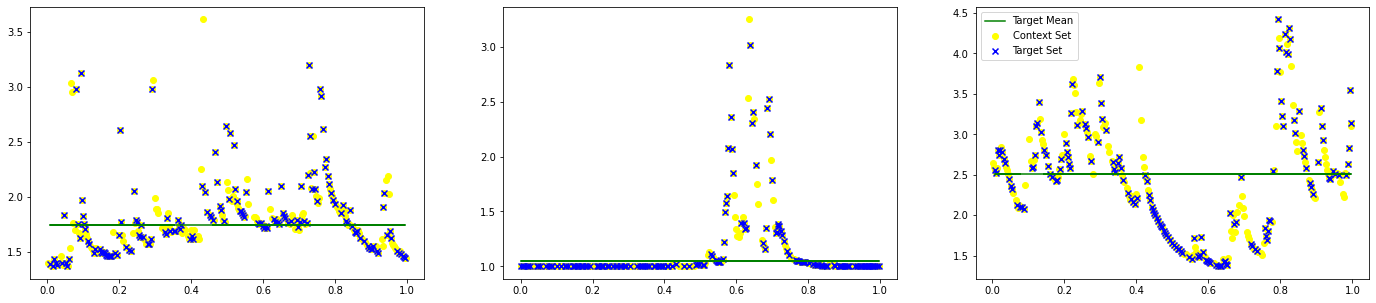

In [285]:
gen = convcnp.data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_train,
                                            df_att = df_att,
                                            batch_size = 16*2,
                                            num_tasks = 256,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            extrapolate = extrapolate_flag,
                                            timeslice = timeslice,
                                            dropout_rate = 0.1,
                                            concat_static_features = False,
                                            min_train_points=min_train_points,
                                            min_test_points=min_test_points,
                                            max_train_points=max_train_points,
                                            max_test_points=max_test_points,
                                            device='cpu',
                                            )
        

task = gen.generate_task()
fig = plt.figure(figsize=(24, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_task(task, i, legend=i==2)
plt.show()

In [286]:
"""for k in task.keys():
    print(task[k].device)"""

'for k in task.keys():\n    print(task[k].device)'

In [292]:
importlib.reload(convcnp.architectures)
from convcnp.architectures import *

In [295]:
%%capture

# Define parameters
static_embedding_location = "after_encoder"
rho_in_channels = 8 if static_embedding_location != "after_encoder" else 8 + static_feature_embedding_dims
static_embedding_in_channels = len(attributes)

# Instantiate ConvCNP
model = ConvCNP(in_channels = len(context_channels),
                #rho=SimpleConv(),
                rho=DepthSepConv1d(in_channels=rho_in_channels, num_layers=7),
                points_per_unit=64*8,
                static_feature_embedding=True,
                static_embedding_in_channels=static_embedding_in_channels,
                static_feature_missing_data=False,
                distribution='gamma')

# Assign model to device
model.to(device)

In [296]:
model.num_params

28855

## Training Methods

With our model in place, let's next define a training procedure. The `train` function below performs one training epoch (as defined by the number of tasks in an epoch from our data generator) as follows:
1. Iterate over the tasks in the epoch
2. For every task, condition on the context set, and make (Gaussian) predictions at the target locations.
3. Compute the log-likelihood of the predictions under the target set.
4. Backpropagate the error from the (negative) log-likelihood to the model parameters 

The `RunningAverage` average object will maintain a running average of the negative log-likelihood. In addition, we provide a plotting function so as to visually monitor the progress of the training procedure.

In [297]:
import importlib
importlib.reload(convcnp.transformations)
from convcnp.transformations import *

In [298]:
def rev_transform(x,a=0,b=0):
    return rev_log_transform(x-1,e=1)
    #return rev_boxcox_transform(x,ld=lambda_OBS_RUN)

def rev_transform_tensor(x,a=0,b=0):
    return torch.exp(x-1)-1
    #return rev_boxcox_transform_tensor(x,ld=lambda_OBS_RUN)

In [299]:
def task_to_device(task,device=device):
    for k in task.keys():
        task[k] = task[k].to(device)
    return task

def loaded_task(task):
    if len(task['x'].shape)==4:
        for k in task.keys():
            if task[k].device=='cuda':
                task[k] = task[k].reshape(task[k].shape[1:])
            else:
                task[k] = task[k].reshape(task[k].shape[1:]).to('cuda')
    else:
        for k in task.keys():
            if task[k].device=='cuda':
                pass
            else:
                task[k] = task[k].to('cuda')
    return task

In [300]:
import scipy.stats

def train(data, model, opt, dist='gaussian'):
    """Perform a training epoch."""
    ravg = RunningAverage()
    ravg_nse = RunningAverage() 
    model.train()
    start_1 = time.time()
    task_obj_list = []
    for step, task in enumerate(data):
        

        
        """elapsed_1 = time.time() - start_1
        print(f'Time for task {step} generation: {elapsed_1}')
        start_2 = time.time()"""
        
        task = loaded_task(task)
        
        y_loc, y_scale = model(task['x_context'], task['y_context'], task['x_target'], task['y_att'], task['feature'], task['m'], embedding=feature_embedding_flag)        
        if dist == 'gaussian':
            y_mean, y_std = y_loc, y_scale
            obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
        elif dist == 'gamma':
            y_mean, y_std = gamma_stats(y_loc, y_scale)
            obj = -gamma_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
        
        obj.backward()
        opt.step()
        opt.zero_grad()
              
        obj_nse = NSE.nse_tensor(rev_transform_tensor(task['y_target']),rev_transform_tensor(task['y_target_val']),rev_transform_tensor(y_mean))
        task_obj_list.append(obj)
        ravg.update(obj.item(), data.batch_size)
        ravg_nse.update(obj_nse.item(), data.batch_size)
        
        """elapsed_2 = time.time() - start_2
        print(f'Time for task {step} processing: {elapsed_2}')"""
        
        """if step % 10 == 0:
            print("step %s -- avg training loss is %.3f" % (step, ravg.avg))"""  
        
        #start_1 = time.time()
    
    plt.plot(task_obj_list)
    plt.show
        
    return ravg.avg, ravg_nse.avg

# Create a fixed set of outputs to predict at when plotting.
x_test = torch.linspace(0., 1.,timeslice)[None, :, None].to(device)


def plot_model_task(model, task, timeslice, idx, legend, dist='gaussian', feature_embedding_flag=True):
    num_functions = task['x_context'].shape[0]
    x_test = torch.linspace(0., 1.,timeslice)[None, :, None].to(device)
    
    # Make predictions with the model.
    model.eval()
    with torch.no_grad():
        y_loc, y_scale = model(task['x_context'], task['y_context'], x_test.repeat(num_functions, 1, 1), task['y_att'], task['feature'],task['m'],embedding=feature_embedding_flag)
        #y_loc_NSE, y_scale_NSE = model(task['x_context'], task['y_context'], task['x_target'], task['y_att'], task['feature'], task['m'], embedding=feature_embedding_flag)

    # Plot the task and the model predictions.
    x_context, y_context = to_numpy(task['x_context'][idx]), to_numpy(task['y_context'][idx][:,0])
    x_target, y_target = to_numpy(task['x_target'][idx]), to_numpy(task['y_target'][idx][:,0])
    #y_mean_NSE, y_std_NSE = to_numpy(y_mean_NSE[idx][:,0]), to_numpy(y_std_NSE[idx][:,0])
    y_target_val = to_numpy(task['y_target_val'][idx][:,0])
    
    if dist == 'gaussian':
        y_mean, y_std = y_loc, y_scale
        y_mean, y_std = to_numpy(y_mean[idx][:,0]), to_numpy(y_std[idx][:,0])
        p05, p95 = y_mean + 2 * y_std, y_mean - 2 * y_std
        #y_mean_NSE, y_std_NSE = y_loc_NSE, y_scale_NSE
    elif dist == 'gamma':
        y_mean, y_std = gamma_stats(y_loc, y_scale)
        y_mean, y_std = to_numpy(y_mean[idx][:,0]), to_numpy(y_std[idx][:,0])
        y_loc, y_scale = to_numpy(y_loc[idx][:,0]), to_numpy(y_scale[idx][:,0])        
        p05 = scipy.stats.gamma.ppf(0.05, y_loc, 0, 1/y_scale)
        p95 = scipy.stats.gamma.ppf(0.95, y_loc, 0, 1/y_scale)
        #y_mean_NSE, y_std_NSE = gamma_stats(y_loc_NSE, y_scale_NSE)

    #nse = NSE.nse(rev_transform(y_target), rev_transform(y_target_val), rev_transform(y_mean_NSE))
    #log_nse = NSE.nse(y_mean_NSE, y_target_val, y_target)
    
    x_context = x_context*timeslice
    x_target = x_target*timeslice
    x_test = to_numpy(x_test[0,:,0])*timeslice
    
    plt.scatter(x_context, rev_transform(y_context), label='Context Set', color='black')
    plt.scatter(x_target, rev_transform(y_target), label='Target Set', color='red')
    #plt.scatter(x_target, rev_transform(y_mean_NSE), label='Target Predictions', color='orange')
    plt.plot(x_target, rev_transform(y_target_val), label='Target Mean', color='green')

    # Plot model predictions.
    plt.plot(x_test, rev_transform(y_mean), label='Model Output', color='blue')
    plt.fill_between(x_test,
                     rev_transform(p95),
                     rev_transform(p05),
                     color='tab:blue', alpha=0.2)
        
    #plt.title("NSE(1): %.3f " % nse)
    #plt.xlabel("Q")
    #plt.ylabel("y-label")
        
    if legend:
        plt.legend()

In [301]:
df_test = df_test_both

# Instantiate data generator for testing.
NUM_TEST_TASKS = 128
gen_test = convcnp.data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test,
                                            df_att = df_att,
                                            batch_size = 16,
                                            num_tasks = NUM_TEST_TASKS,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            extrapolate = extrapolate_flag,
                                            concat_static_features=False,
                                            timeslice = timeslice,
                                            min_train_points=min_train_points,
                                            min_test_points=min_test_points,
                                            max_train_points=max_train_points,
                                            max_test_points=max_test_points,
                                            device = 'cpu'
                                            )

In [302]:
def get_batch_size(x):
    if x.__class__ == 'torch.utils.data.dataloader.DataLoader':
        return x.dataset.gen.batch_size
    else:
        return x.batch_size

In [303]:
def test(gen_test,model,dist='gaussian',fig_flag=False):
    # Compute average task log-likelihood.
    ravg = RunningAverage()
    ravg_nse = RunningAverage()
    
    model.eval()
    #start = time.time()
    
    with torch.no_grad():
        for step, task in enumerate(gen_test):
            task = loaded_task(task)
            y_loc, y_scale = model(task['x_context'], task['y_context'], task['x_target'], task['y_att'], task['feature'], task['m'], embedding=feature_embedding_flag)        
            if dist == 'gaussian':
                y_mean, y_std = y_loc, y_scale
                obj = -gaussian_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
            elif dist == 'gamma':
                y_mean, y_std = gamma_stats(y_loc, y_scale)
                obj = -gamma_logpdf(task['y_target'], y_loc, y_scale, 'batched_mean')
            
            batch_size = get_batch_size(gen_test)
            
            obj_nse = NSE.nse_tensor(rev_transform_tensor(task['y_target']),rev_transform_tensor(task['y_target_val']),rev_transform_tensor(y_mean))        
            ravg.update(obj.item(), batch_size)
            #print(batch_size)
            ravg_nse.update(obj_nse.item(), batch_size)

    if fig_flag:
        fig = plt.figure(figsize=(24, 15))
        for i in range(3):
            plt.subplot(3, 1, i + 1)
            plot_model_task(model, task, timeslice, idx=i, legend=i==2, dist=dist)
        plt.show()

    #elapsed = time.time() - start        
        print('Test NLL: %.3f -- NSE: %.3f -- time: %.3f' % (ravg.avg, ravg_nse.avg, elapsed))
    
    return ravg.avg


## Training loop for the model

Now we can write a standard PyTorch optimization loop. First, we instantiate an optimizer (here we use an Adam optimizer). Then, we simply iterate for as many epochs as necessary to train the model. Every so often we will print the training error (since the data are generated on the fly, this is also a reasonable estimator for the held out error), and produce a plot demonstrating the model performance. Note that the next block of code will train the model for 100 epochs. This may take some time, and it is highly recommended to do so with a GPU!

In [304]:
#torch.multiprocessing.set_start_method('fork',force=True)
#importlib.reload(convcnp.data_hydro_2_extended)
importlib.reload(convcnp.convcnp_architectures)
from convcnp.convcnp_architectures import *

In [305]:
from convcnp.data_loader_pytorch import *
train_dataloader = DataLoader(dataset=HydroDataset(gen,num_tasks_epoch=256*4), batch_size=1, shuffle=False, num_workers=24, pin_memory=True)
test_dataloader = DataLoader(dataset=HydroDataset(gen_test,num_tasks_epoch=128), batch_size=1, shuffle=False, num_workers=16, pin_memory=True)

In [306]:
from IPython import display

Epoch 20 ¦ train NLL: 2.617 ¦ test NLL: 3.070 ¦ train NSE: -476.607 ¦ time: 104.665


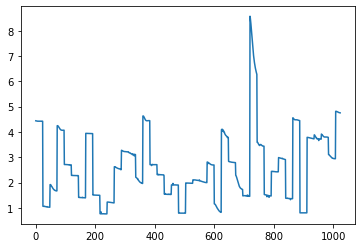

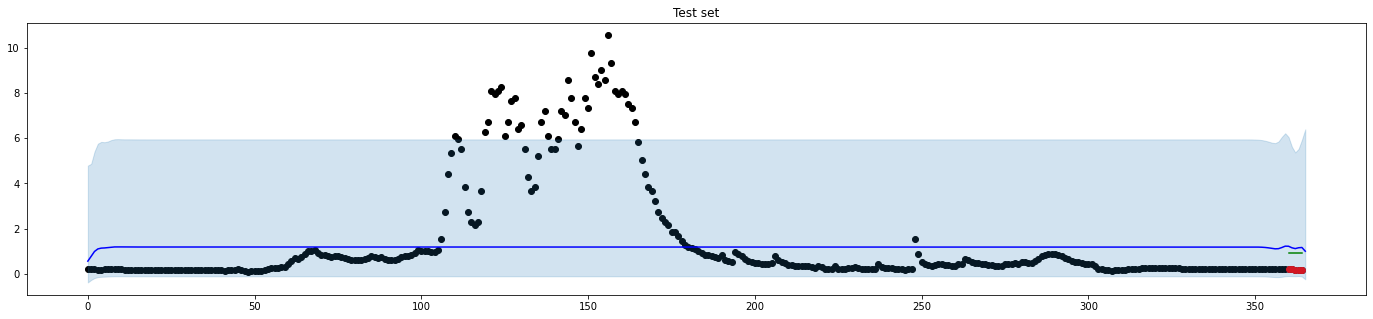

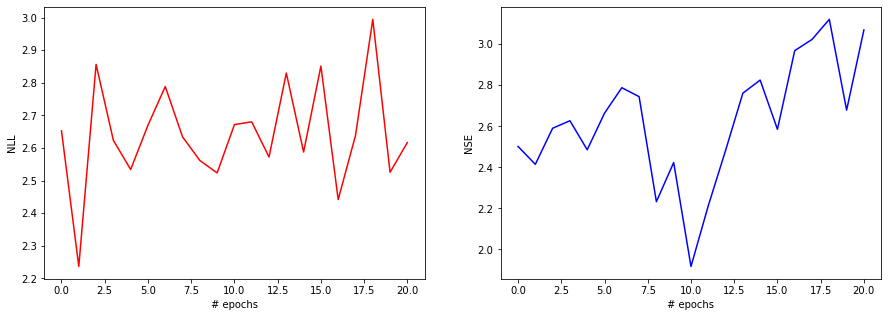

KeyboardInterrupt: 

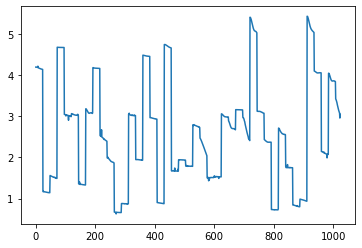

Exception in thread Thread-1775:
Traceback (most recent call last):
  File "/home/donal/miniconda3/lib/python3.7/threading.py", line 926, in _bootstrap_inner
    self.run()
  File "/home/donal/miniconda3/lib/python3.7/threading.py", line 870, in run
    self._target(*self._args, **self._kwargs)
  File "/home/donal/miniconda3/lib/python3.7/site-packages/torch/utils/data/_utils/pin_memory.py", line 25, in _pin_memory_loop
    r = in_queue.get(timeout=MP_STATUS_CHECK_INTERVAL)
  File "/home/donal/miniconda3/lib/python3.7/multiprocessing/queues.py", line 113, in get
    return _ForkingPickler.loads(res)
  File "/home/donal/miniconda3/lib/python3.7/site-packages/torch/multiprocessing/reductions.py", line 294, in rebuild_storage_fd
    fd = df.detach()
  File "/home/donal/miniconda3/lib/python3.7/multiprocessing/resource_sharer.py", line 57, in detach
    with _resource_sharer.get_connection(self._id) as conn:
  File "/home/donal/miniconda3/lib/python3.7/multiprocessing/resource_sharer.py", 

In [281]:
torch.autograd.set_detect_anomaly(True)

# Some training hyper-parameters:
LEARNING_RATE = 1e-3
NUM_EPOCHS = 500
PLOT_FREQ = 1
dist = 'gamma'


# Initialize optimizer
opt = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

train_obj_list, train_nse_list, test_obj_list, epoch_list = [], [], [], []

# Run the training loop.
for epoch in range(NUM_EPOCHS):
    # Compute training objective.
    start_time = time.time()
    train_obj, train_nse = train(train_dataloader, model, opt, dist=dist)

    epoch_list.append(epoch)
    train_obj_list.append(train_obj)
    train_nse_list.append(train_nse)
    
    test_obj = test(test_dataloader,model,dist=dist)
    test_obj_list.append(test_obj)
    
    elapsed = time.time() - start_time
    
    #print('Epoch %s ¦ train NLL: %.3f ¦ test NLL: %.3f ¦ train NSE: %.3f ¦ time: %.3f' % (epoch, train_obj, test_obj, train_nse, elapsed))

    # Plot model behaviour every now and again.
    if epoch % PLOT_FREQ == 0:
        task = task_to_device(gen_test.generate_task())
        fig = plt.figure(figsize=(24, 5))
        for i in range(1):
            plt.subplot(1, 1, i + 1)
            plot_model_task(model, task, timeslice=timeslice, idx=i, legend=i==2, dist=dist)
        plt.title('Test set')
        display.clear_output(wait=True)
        #display.display(plt.gcf())
        #plot training loss

        print('Epoch %s ¦ train NLL: %.3f ¦ test NLL: %.3f ¦ train NSE: %.3f ¦ time: %.3f' % (epoch, train_obj, test_obj, train_nse, elapsed))

        plot_training_loss(train_obj_list, test_obj_list)
        #plt.show()
    
    else:
        pass

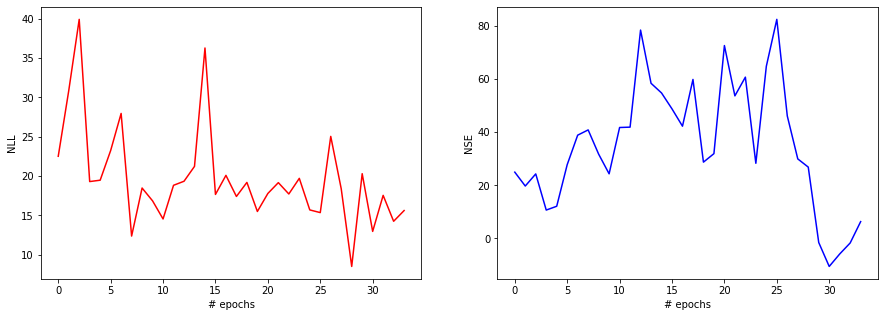

In [76]:
#plot training loss
plot_training_loss(train_obj_list, test_obj_list)

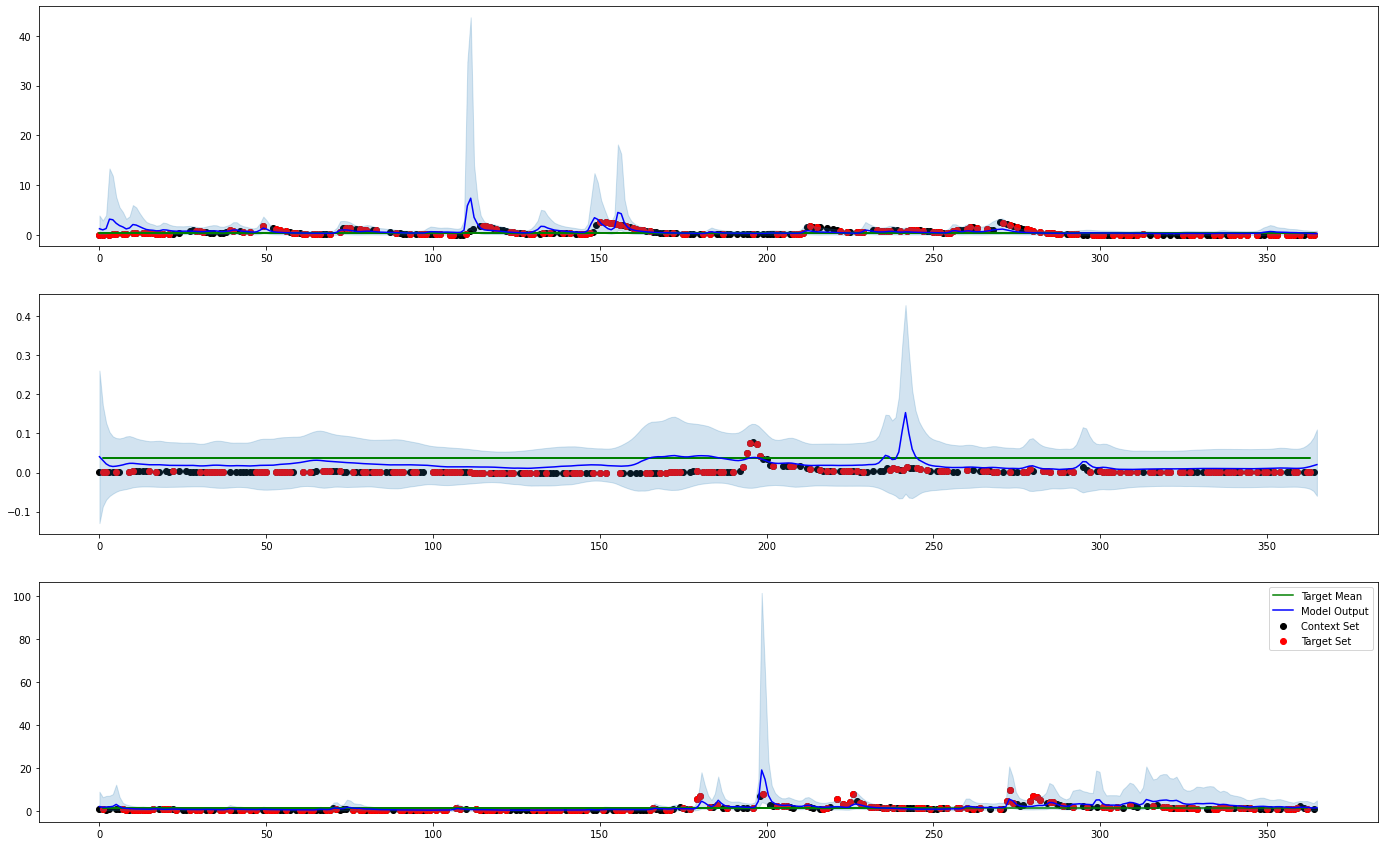

Test NLL: 0.653 -- NSE: -inf -- time: 106.939


"task = task_to_device(gen_test.generate_task())\nfig = plt.figure(figsize=(24, 5))\nfor i in range(3):\n    plt.subplot(1, 3, i + 1)\n    plot_model_task(model, task, timeslice=timeslice, idx=i, legend=i==2, dist=dist)\nplt.title('Test set')\nplt.show()"

In [256]:
gen_for_test = convcnp.data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_train,
                                            df_att = df_att,
                                            batch_size = 16,
                                            num_tasks = 32,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            extrapolate = extrapolate_flag,
                                            timeslice = timeslice,
                                            dropout_rate = 0,
                                            concat_static_features = False,
                                            min_train_points=min_train_points,
                                            min_test_points=min_test_points,
                                            max_train_points=max_train_points,
                                            max_test_points=max_test_points,
                                            device='cpu',
                                            )
        

tester = DataLoader(dataset=HydroDataset(gen_for_test,num_tasks_epoch=64), batch_size=1, shuffle=False, num_workers=24, pin_memory=True)
test(tester,model,dist='gamma',fig_flag=True)
"""task = task_to_device(gen_test.generate_task())
fig = plt.figure(figsize=(24, 5))
for i in range(3):
    plt.subplot(1, 3, i + 1)
    plot_model_task(model, task, timeslice=timeslice, idx=i, legend=i==2, dist=dist)
plt.title('Test set')
plt.show()"""

## Evaluation 

We can also evaluate the trained model to get better estimates of its performance. To do so, we will first introduce an additional data generator that will generate far more tasks for us. Then, we will loop over many tasks, and compute (and print) the average log-likelihood.

In [ ]:
"""%%capture
#load model
##model = TheModelClass(*args, **kwargs)
PATH = '../../saved_models/model_022.pt'
model.load_state_dict(torch.load(PATH))
model.eval()"""

In [ ]:
"""model_number = 23
save_model_name = f'model_{model_number}_{dist}_static-features_{static_embedding_location}_{s_date_tr}_to_{e_date_tr}'
save_model_name"""

In [ ]:
PATH = r'..\..\saved_models\model_022.pt'
torch.save(model.state_dict(),PATH)

## Test NSE performance at 365/1-day ahead task

In [257]:
importlib.reload(convcnp.data_hydro_2_extended)
from convcnp.data_hydro_2_extended import *
importlib.reload(NSE)
from metrics import *
import scipy.stats
df_test = df_test_both

53


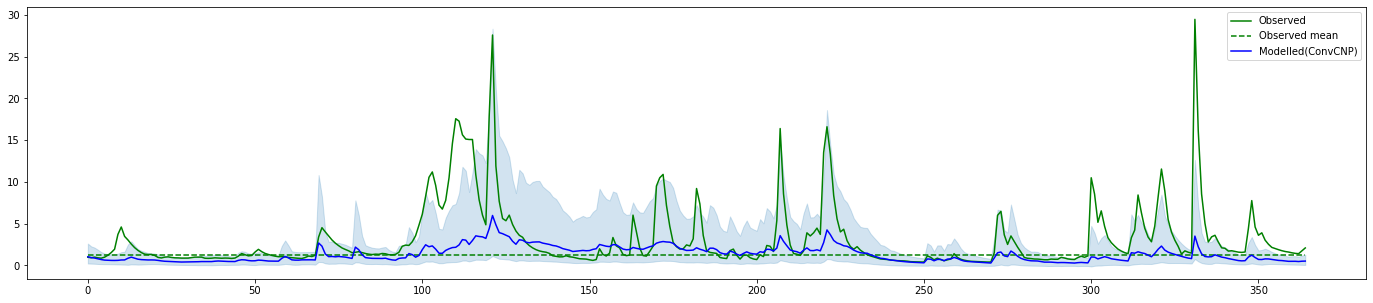

1. Basin hru_01047000 (period: 2008-2009): LL=-0.012 -- NSE=0.100 -- time=13.955


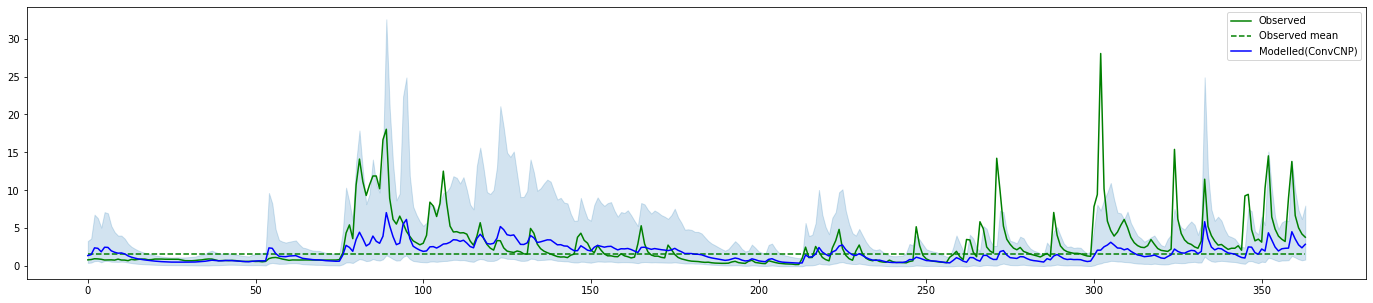

2. Basin hru_01169000 (period: 2003-2004): LL=-0.007 -- NSE=0.388 -- time=13.409


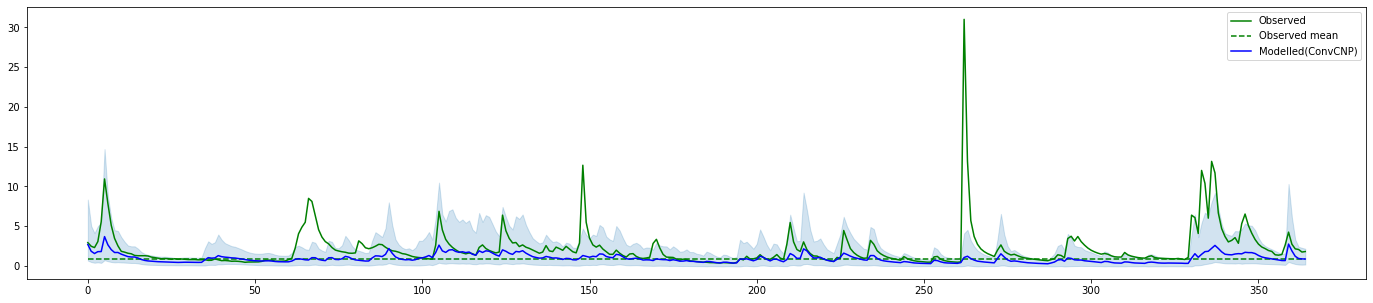

3. Basin hru_01539000 (period: 2004-2005): LL=-0.009 -- NSE=-0.129 -- time=13.755
WARNING


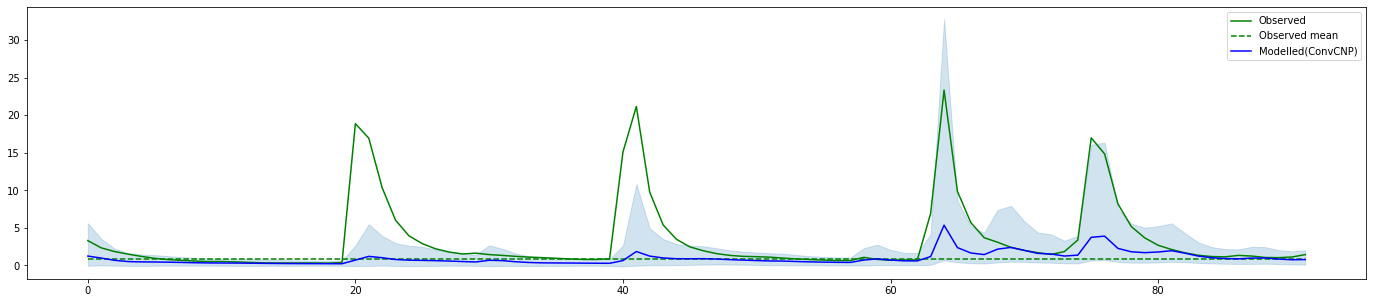

4. Basin hru_01547700 (period: 1996-1997): LL=-0.010 -- NSE=0.004 -- time=3.555


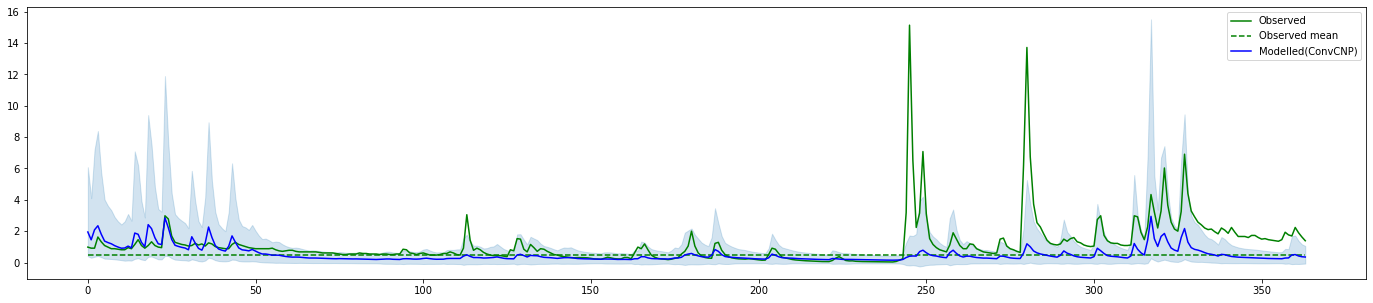

5. Basin hru_01669000 (period: 2006-2007): LL=-0.008 -- NSE=-0.084 -- time=13.372


KeyboardInterrupt: 

In [258]:
# Instantiate data generator for testing.
NUM_TEST_TASKS = 10
gen_test = convcnp.data_hydro_2_extended.HydroGenerator(
                                            dataframe=df_test,
                                            df_att = df_att,
                                            batch_size = 16,
                                            num_tasks = NUM_TEST_TASKS,
                                            channels_c = context_channels,
                                            channels_t = target_channels,
                                            channels_att = attributes,
                                            channels_t_val = target_val_channel,
                                            context_mask = context_mask,
                                            target_mask = target_mask,
                                            concat_static_features = False,
                                            extrapolate = True,
                                            timeslice = 365,
                                            min_train_points=364,
                                            min_test_points=1,
                                            max_train_points=364,
                                            max_test_points=1)

out = np.array([])
out_2 = np.array([])

# Compute average task log-likelihood.
basins = df_test['hru08'].unique().tolist()
#basins = ['hru_01030500','hru_01047000']
print(len(basins))
b=0
for basin in basins[:]:
    
    b+=1
    
    ravg = RunningAverage()
    ravg_nse = RunningAverage()
    rnum = RunningAverage()
    rden = RunningAverage()
    model.eval()
    start = time.time()
    
    pred_mu = np.array([])
    pred_sigma = np.array([])
    pred_loc = np.array([])
    pred_scale = np.array([])
    observations = np.array([])
    DOY = np.array([])
    YR = np.array([])
    HRU = np.array([])
    
    alpha_nse = np.array([])
    beta_nse = np.array([])
    nse_index = np.array([])
    fhv = np.array([])
    flv = np.array([])
    fms = np.array([])
    
    with torch.no_grad():    
        years = df_test['YR'][df_test['hru08']==basin].unique().tolist()
        years = sorted(years)[1:]
        duration = 1
        y = np.random.randint(len(years)-duration)
        for year in years[y:y+duration]:
        #for year in years[:]:
            task = gen_test.generate_test_task(year,basin)
            chunk_size = 100
            chunks = np.arange(0,task['x_context'].shape[0],chunk_size)
            #print(chunks)
            minitask = task.copy()
            for i in range(len(chunks)):
                #print("chunk",i)
                #print(task[k].shape)
                if i+1 == len(chunks):
                    s = chunks[i]
                    e = task['x'].shape[0]
                else:
                    s = chunks[i]
                    e = chunks[i+1]

                for k,v in task.items():
                    minitask[k] = task[k][s:e] 
                
                minibatch_size = minitask['x_context'].shape[0]
                y_mean, y_std = model(minitask['x_context'], minitask['y_context'], minitask['x_target'],minitask['y_att'], minitask['feature'],minitask['m'],embedding=feature_embedding_flag)
                #obj = -gaussian_logpdf(minitask['y_target'], y_mean, y_std, 'batched_mean')
                obj = -gamma_logpdf(minitask['y_target'], y_mean, y_std, 'batched_mean')
                obj_nse = NSE.nse_tensor_batch(rev_transform_tensor(minitask['y_target']),rev_transform_tensor(minitask['y_target_val']),rev_transform_tensor(y_mean))
                
                if dist == 'gamma':
                    y_loc = y_mean
                    y_scale = y_std
                    g_mean = torch.distributions.gamma.Gamma(y_mean, y_std).mean
                    g_var = torch.distributions.gamma.Gamma(y_mean, y_std).variance
                    y_mean = g_mean
                    y_std = torch.sqrt(g_var)
                
                num = NSE.squared_dist(rev_transform_tensor(minitask['y_target']),rev_transform_tensor(y_mean))
                den = NSE.squared_dist(rev_transform_tensor(minitask['y_target']),rev_transform_tensor(minitask['y_target_val']))
                
                #print(obj.item(), obj_nse.item(), num.item(), den.item())
                #print(minitask['y_target'].shape)
                
                ravg.update(obj.item() / minibatch_size, minibatch_size)
                ravg_nse.update(obj_nse.item() / minibatch_size, minibatch_size)
                rnum.update(num.item(), minibatch_size)
                rden.update(den.item(), minibatch_size)
                
                observations = np.append(observations, to_numpy(minitask['y_target']))
                pred_mu = np.append(pred_mu, to_numpy(y_mean))
                pred_sigma = np.append(pred_sigma, to_numpy(y_std))
                if dist=='gamma':
                    pred_loc = np.append(pred_loc, to_numpy(y_loc))
                    pred_scale = np.append(pred_scale, to_numpy(y_scale))
                DOY = np.append(DOY, np.arange(s+1,e+1))
                YR = np.append(YR, np.ones(minibatch_size)*year)
                HRU = np.append(HRU, np.array([basin] * minibatch_size))
                
        alpha_nse = np.append(alpha_nse, calc_alpha_nse(observations,pred_mu))
        beta_nse = np.append(beta_nse, calc_beta_nse(observations,pred_mu))
        nse_index = np.append(nse_index, calc_nse(observations,pred_mu))
        fhv = np.append(fhv, calc_fdc_fhv(observations,pred_mu))
        flv = np.append(flv, calc_fdc_flv(observations,pred_mu))
        fms = np.append(fms, calc_fdc_fms(observations,pred_mu))    
            
        out_basin = np.transpose(np.vstack((HRU,YR,DOY,observations,pred_mu,pred_sigma)))
        out_basin_2 = np.transpose(np.vstack((alpha_nse,beta_nse,nse_index,fhv,flv,fms)))
        
        fig = plt.figure(figsize=(24, 5))
        
        x = np.arange(len(observations))
        
        # Plot model predictions.
        plt.plot(x,rev_transform(observations), label='Observed', color='green')
        plt.plot(x,rev_transform(np.ones(len(pred_mu))*pred_mu.mean()), label='Observed mean', linestyle='dashed', color='green')
        plt.plot(x,rev_transform(pred_mu), label='Modelled(ConvCNP)', color='blue')
        
        if dist=='gaussian':
            plt.fill_between(x,
                             rev_transform(pred_mu + 2 * pred_sigma),
                             rev_transform(pred_mu - 2 * pred_sigma),
                             color='tab:blue', alpha=0.2)

        elif dist=='gamma':
            p05 = scipy.stats.gamma.ppf(0.05, pred_loc, 0, 1/pred_scale)
            p95 = scipy.stats.gamma.ppf(0.95, pred_loc, 0, 1/pred_scale)
            plt.fill_between(x,
                            rev_transform(p05),
                            rev_transform(p95),
                            color='tab:blue', alpha=0.2)
        
        plt.legend()
        plt.show()

        nse_2 = 1 - rnum.avg/rden.avg
        elapsed = time.time() - start        
        print(f'{b}. Basin {basin} (period: {years[y]}-{years[y+duration]}): LL=%.3f -- NSE=%.3f -- time=%.3f' % (-ravg.avg, calc_nse(observations,pred_mu), elapsed))
    
    if out.shape[0]!=0:
        out = np.vstack((out,out_basin))
        out_2 = np.vstack((out_2,out_basin_2))
    else:
        out = out_basin
        out_2 = out_basin_2

In [119]:
df_output = pd.DataFrame(out,columns=['HRU','YR','DOY','OBS_RUN','MOD_RUN_MU','MOD_RUN_SIGMA'])
df_output_2 = pd.DataFrame(out_2, columns=['alpha_nse','beta_nse','nse_index','fhv','flv','fms'])

In [120]:
"""df_output_test_both_40basins = df_output.copy()
df_output_test_both_40basins_2 = df_output_2.copy()"""

'df_output_test_both_40basins = df_output.copy()\ndf_output_test_both_40basins_2 = df_output_2.copy()'

26


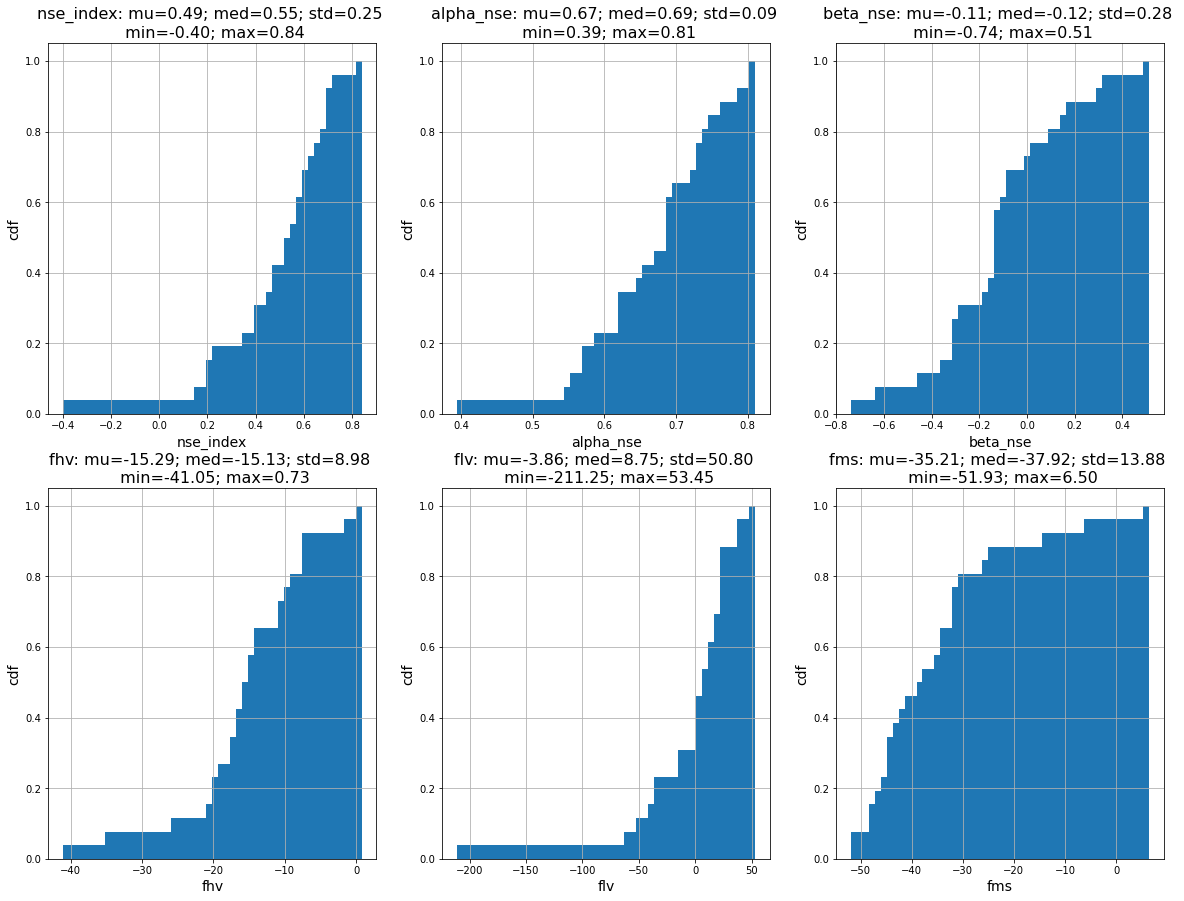

In [121]:
hrus = df_output['HRU'].unique()
nse_array = np.array([])
for hru in hrus:
    df_hru = df_output[df_output['HRU']==hru]
    obs = rev_transform(df_hru['OBS_RUN'].values.astype(np.float))
    mean_obs = np.ones(len(obs))*obs.mean()
    #print(mean_obs)
    mod = rev_transform(df_hru['MOD_RUN_MU'].values.astype(np.float))
    nse_array = np.append(nse_array, NSE.nse(obs,mean_obs,mod))

#print(f"Median NSE = {np.median(nse_array)}")
#print(f"Mean NSE = {nse_array.mean()}")
#print(f"NSE std = {nse_array.std()}")
print(len(nse_array))

list_metrics = ['nse_index','alpha_nse','beta_nse','fhv','flv','fms']

i = 0
fig = plt.figure(figsize=[20,15])
for m in list_metrics:
    i += 1
    plt.subplot(2,3,i)
    plt.hist(df_output_2[m], bins=50, density=True, 
         histtype='stepfilled',
         cumulative=True)
    plt.grid()
    
    plt.ylabel("cdf",fontsize = 14)
    plt.xlabel(m,fontsize=14)
    plt.title("%s: mu=%.2f; med=%.2f; std=%.2f \n min=%.2f; max=%.2f" % (m, df_output_2[m].mean(), df_output_2[m].median(), df_output_2[m].std(), df_output_2[m].min(), df_output_2[m].max()), fontsize=16)
    #plt.show()

155


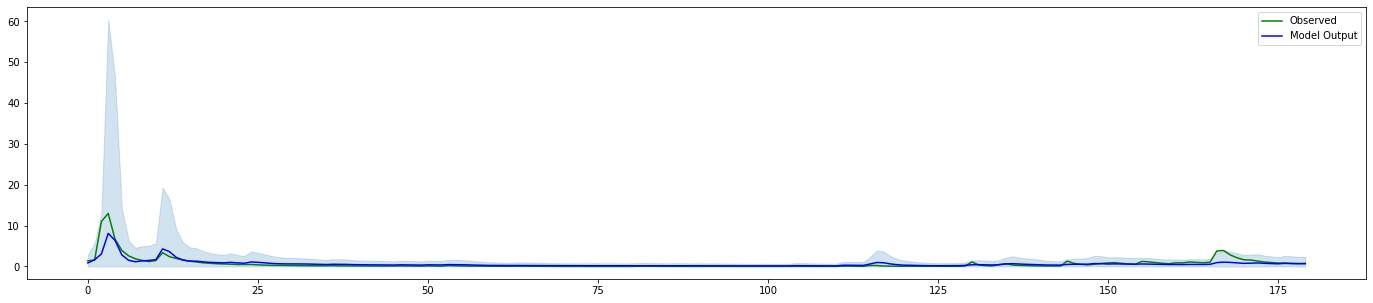

In [116]:
time_slice = 180
x = np.arange(time_slice)
hru_list = df_output['HRU'].unique()
rand = np.random.randint(len(hru_list))
hru_rand = hru_list[rand]

i = np.random.randint(len(df_output['OBS_RUN'][df_output['HRU']==hru_rand])-time_slice)
print(i)

fig = plt.figure(figsize=(24, 5))

obs = df_output['OBS_RUN'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
pred_mu = df_output['MOD_RUN_MU'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
pred_sigma = df_output['MOD_RUN_SIGMA'][df_output['HRU']==hru_rand][i:i+time_slice].values.astype(np.float)
                         
# Plot model predictions.
plt.plot(x,rev_transform(obs), label='Observed', color='green')
plt.plot(x,rev_transform(pred_mu), label='Model Output', color='blue')

show_std = True

if show_std:
    plt.fill_between(x,
                     rev_transform(pred_mu + 2 * pred_sigma),
                     color='tab:blue', alpha=0.2)

plt.legend()
plt.show()

## Test with known datanse_array

In [ ]:
import pickle
path = "test_tasks/generate_test_task_0.pkl"
a_file = open(path, "rb")
task = pickle.load(a_file)
a_file.close()

In [ ]:
import importlib
importlib.reload(convcnp.feature_mask)

In [ ]:
#import convcnp.feature_mask as mask
task = mask.task_mask(task, context_mask, target_mask)

In [ ]:
# Compute average task log-likelihood.
batch_size = task['x_context'].shape[0]
ravg = RunningAverage()
model.eval()
with torch.no_grad():
    y_mean, y_std = model(task['x_context'], task['y_context'], task['x_target'],task['f'],task['m'],embedding=feature_embedding_flag)
    obj = -gaussian_logpdf(task['y_target'], y_mean, y_std, 'batched_mean')
        
    ravg.update(obj.item() / gen_test.batch_size, gen_test.batch_size)
        
    fig = plt.figure(figsize=(24, 25))
    for i in range(5):
        plt.subplot(5, 1, i + 1)
        plot_model_task(model, task, idx=i, legend=i==2)
    plt.show()
    
elapsed = time.time() - start        
print('Model averages a log likelihood of %.3f on unseen tasks -- time: %.3f' % (-ravg.avg, elapsed))

In [ ]:
torch.distributions.gamma.Gamma([1,2,3],1,1)